In [13]:
import matplotlib.pyplot as plt

def dibujar_interseccion_esfera_foton(esfera, foton):
  interseccion, n = esfera.interseccion(foton)
    
  # Dibujamos la esfera
  x, y = esfera.getPlotCoords()
  plt.plot(x, y)
  plt.xlim(-2,2)
  plt.ylim(0,4)

  # Dibujar origen y vector de direccion
  plt.scatter(foton.pos[0], foton.pos[1], c='b')
  plt.quiver(foton.pos[0], foton.pos[1],
            foton.dire[0], foton.dire[1], color='b')
  if n[0] != None:
    plt.quiver(interseccion[0], interseccion[1], n[0], n[1], color='g')
  plt.axis('equal')
  

  # Dibujamos segmento de trayectoria
  plt.plot([foton.pos[0], interseccion[0]], [foton.pos[1], interseccion[1]], c='b')

  plt.scatter(interseccion[0], interseccion[1], c='r')
  # plt.scatter(interseccion_2[0], interseccion_2[1], c='r')
  plt.show()
  
def draw_fotones_hist(fotones, esfera, expand = True):
  x_esf, y_esf = esfera.getPlotCoords()
  # Hacemos la figura más grande
  plt.figure(figsize=(10, 10))
  plt.plot(x_esf, y_esf)
  # plt.xlim(-2, 2)
  # plt.ylim(0, 4)
  plt.gca().set_aspect('equal', adjustable='box')
  
  for foton in fotones:
    pos_hist = [p[0] for p in foton.poshist]
    x = [p[0] for p in pos_hist]
    y = [p[1] for p in pos_hist]
    plt.plot(x, y, c='b', alpha=0.05)
    
    # Dibujamos el vector de salida en la última posición
    if expand:
      plt.quiver(x[-1], y[-1], foton.dire[0], foton.dire[1], color='r')
    plt.quiver(x[-1], y[-1], foton.dire[0], foton.dire[1], color='r')
  
  plt.show()

In [2]:
from materiales.SimpleMaterial import MixedComplexMaterial
from propiedades.IndicesRefraccion import nComplex
from utilidades.aleatorios import *
from entidades.estructura import Esfera, Entorno
from entidades.fuente import FuenteMonocromatica
from entidades.interfase import interactuar_interfase
from entidades.SimulatedPhoton import SimulatedPhoton




# Entorno
entorno = Entorno()


# Esfera
radio = 1000
centro = np.array([0, 1500, 0])
n1 = nComplex(1.6, 0)
n2 = nComplex(1.456, 1e-3)

n_ext = nComplex(1, 0)
materialComplejo_int = MixedComplexMaterial(n=[n1,n2], fs=[0.99, 0.01])
materialComplejo_ext = MixedComplexMaterial(n=[n_ext], fs=[1])

ide = 1 
esfera1 = Esfera(1, centro, radio, material_int = materialComplejo_int, estructura_ext=entorno)

# Fuente fotones
fuente = FuenteMonocromatica(532, 0)

d_arbitraria_ampliacion = radio

[None, None, None] [None, None, None]


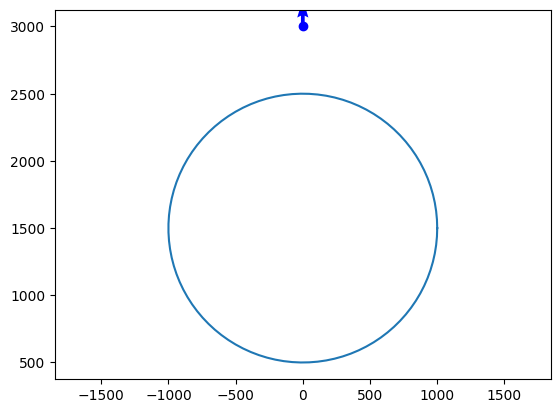

In [18]:
# foton_in = SimulatedPhoton(1, [0, 1000, 0], dire = [0, 1 ,0], estructura=esfera1)
foton_out = SimulatedPhoton(1, [0, 3000, 0], dire = [0, 11 ,0])
p_int, n = esfera1.interseccion(foton_out)
print(p_int, n)
dibujar_interseccion_esfera_foton(esfera1, foton_out)

In [ ]:
import time

fotones = fuente.emitirN(500, 0, 500, std_ang=np.pi/6)
# fotones_activos = []
fotones_inactivos = []
fotones_absorbidos = []
time_start = time.time()
# Fotones absorbidos
n_abs = 0
# alfa = materialComplejo.alfa(fotones[0].lamda)

estructuras = [esfera1]

for f in fotones:
  # Esta lógica hay que cambiarla
  for estructura in estructuras:
    while True:
      p_int, n = estructura.interseccion(f)
      if p_int[0]==None:
        f.actualizarPos(f.pos+f.dire*d_arbitraria_ampliacion)
        fotones_inactivos.append(f)
        break
      
      # Comprobamos si se absorbe antes de interaccionar con una interfase
      l_pos = np.linalg.norm(p_int-f.pos)
      alfa = f.estructura.material.alfa(f.lamda)
      absorbido, labs = probAbs(l_pos, alfa)
      if absorbido:
        n_abs += 1
        f.actualizarPos(f.pos + f.dire*labs)
        fotones_inactivos.append(f)
        fotones_absorbidos.append(f)
        break
      
      # Si no es absorbido, calculamos la interacción con la interfase
      try:
        if f.estructura != estructura:
          estructura_foton = estructura.estructura_ext
          estructura_transmitida = estructura
        else:
          estructura_foton = estructura
          estructura_transmitida = estructura.estructura_ext
        
        n_foton = estructura_foton.material.indice_refraccion.calcular(f.lamda)
        n_trans = estructura_transmitida.material.indice_refraccion.calcular(f.lamda)
        new_dire, result = interactuar_interfase(n, f, n_foton=n_foton, nt = n_trans)
      except:
        raise Exception("Error")
      
      # Si se refleja cambiamos su posición y dirección
      if result == "reflect":
        f.actualizarPos(p_int)
        f.actualizarDire(new_dire)
        continue
      
      # Si se refracta cambiamos su posición, dirección y espacio en el que está
      if result == "refract":
        f.actualizarPos(p_int)
        f.actualizarDire(new_dire)
        f.estructura = estructura_transmitida
        continue
      
time_end = time.time()
print("Tiempo de ejecución: ", time_end - time_start)
draw_fotones_hist(fotones_inactivos, esfera)
print("Fotones absorbidos: ", n_abs)
print("Fotones total: ", len(fotones))